In [1]:
# my modules imports
from model import SEIR

    # utils
from utils import draw_input_params, nb_inputs
from utils import extract_int_value, get_max_load_intensive_care
from utils import idx_to_keys, key_to_idx, input_params, ykeys, box_colors, plotting_names
from utils import Monte_Carlo_sampling, lhs
    
    # plotting
from utils_plotting import plot_morris, plot_sobol, plot_sobol_time

# other imports
from pprint import pprint
import numpy as np
from scipy.integrate import RK45, odeint
import matplotlib.pyplot as plt

# bokeh plotting
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import row, column
from bokeh.models import PrintfTickFormatter
from bokeh.models import CustomJS, DateRangeSlider
from bokeh.models import Legend, ColumnDataSource, Label, LabelSet, Range1d
from bokeh.palettes import magma, viridis
output_notebook(hide_banner=True)

from ipywidgets import interact, IntSlider, Dropdown, FloatSlider


In [2]:
debug = False
seed = 1000

In [3]:
if(debug):
    x = draw_input_params(seed)
    model = SEIR(x)
    model.prettyprint()
    model.step(dt = 1.0) # dt in days 
    model.prettyprint()

In [4]:
# function used to quikcly get integer results from input_params
def f(input_params, step_in_day = 1.0, tend = 200.0, verbose = False):
    model = SEIR(input_params)
    
    if(verbose):
        model.prettyprint()
        
    fcn = model.get_fcn()
    y_ini = model.get_state()

    # in number of days
    tini = input_params[key_to_idx['t0']]
    tend = tini+tend # in days
    number_of_steps = int((tend-tini)/step_in_day)
    
    t_simu = np.linspace(tini,tend,number_of_steps)
    
    rtol, atol = 1e-3, 1e-6 # default values
    solution = odeint(func = fcn, t = t_simu, y0 = y_ini) 
    
    sol, period = extract_int_value(solution, step_in_day)

    return sol, period

## Q1)

In [5]:
def plot_solution(seed = None, verbose = False):
    x = draw_input_params(seed)
    tini = x[key_to_idx['t0']]
    tend = 200.0
    sol, period = f(x, tend = tend)
    
    t = np.linspace(tini, tini+tend, int(tend/period)) # t for printing where 1 day = 1 value.
    
    max_time, max_U = get_max_load_intensive_care(sol, period)
    
    print('Max intensive care load at days {} with {} patients.'.format(max_time, max_U))
    
    fig_sol = figure(plot_height=450, plot_width=900, title="Solution")
    
    legend_it = []
    for idx, (key, name) in enumerate(plotting_names.items()):
        c = fig_sol.x(t, sol[:,idx], line_width=1, color = box_colors[key], alpha=0.9, muted_color=box_colors[key], muted_alpha=0.01) # legend_label="Speed")
        legend_it.append((name, [c]))
        
    legend = Legend(items=legend_it)
    legend.click_policy="mute"
    fig_sol.add_layout(legend, 'right')

    show(fig_sol, notebook_handle=True)
    

In [6]:
plot_solution(seed = seed)

Max intensive care load at days 67 with 175587 patients.


In [7]:
def Monte_Carlo_Umax(N = 100):
    list_U = []
    list_times = []
    
    for k in range(N): 
        x = draw_input_params()
        model = SEIR(x)

        fcn = model.get_fcn()
        y_ini = model.get_state()
        
        step_in_day = 0.1 # 0.1 : 10 points per day
        tini = 0.
        tend = 200.0
        number_of_steps = int((tend-tini)/step_in_day)

        t = np.linspace(tini,tend,number_of_steps)

        rtol, atol = 1e-3, 1e-6 # default values
        
        solution = odeint(func = fcn, t = t, y0 = y_ini)
    
        sol, period = extract_int_value(solution, step_in_day)
        max_time, max_U = get_max_load_intensive_care(sol, period)
        list_U.append(max_U)
        list_times.append(max_time)
    
    return np.array(list_U), np.array(list_times)

In [8]:
N=1000
list_U, list_times = Monte_Carlo_Umax(N=N)

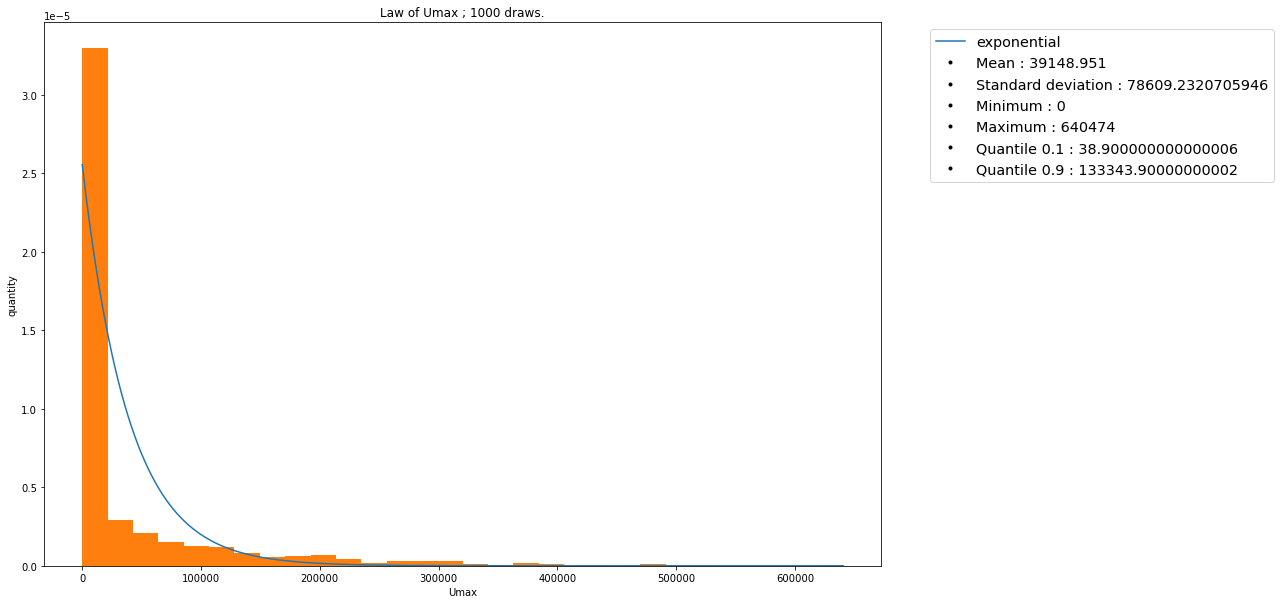

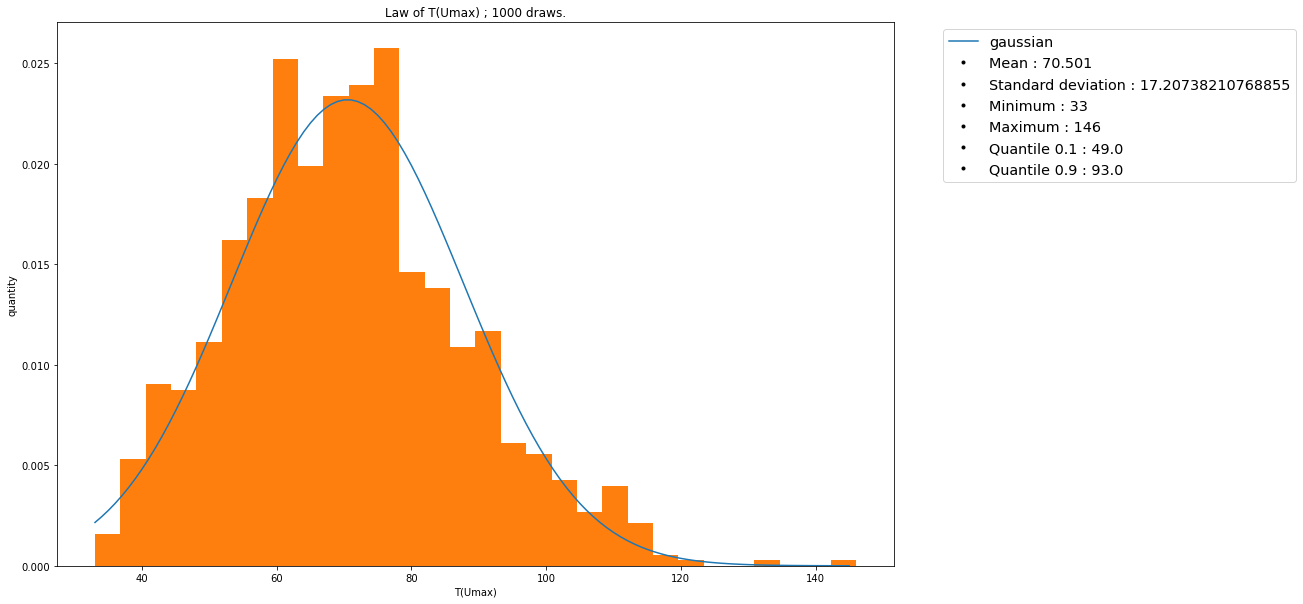

In [9]:
from scipy.stats import chi2, norm, poisson, expon
bins = 30

def get_law(array, bins, name, law = None, name_law = '', savefig = None):
    mean, std = np.mean(array), np.std(array)
    m, M = np.min(array), np.max(array)
    q10, q90 = np.quantile(array, q=0.1),np.quantile(array, q=0.9)
    
    dico = {
        'Mean' : mean,
        'Standard deviation' : std,
        'Minimum' : m,
        'Maximum' : M,
        'Quantile 0.1':q10,
        'Quantile 0.9':q90
    }
    
    N = array.shape[0]
    
    fig, ax = plt.subplots(figsize = (15,10))

    if(law!=None):
        x = np.arange(m, M)
        y = law(x, mean, std) # scale = 1/lambda = Esp(U)
        ax.plot(x,y, label = name_law)
        
    ax.hist(array, bins = bins , density = True)
    
    ax.set_title('Law of {} ; {} draws.'.format(name, N), fontsize=12)
    ax.set_xlabel(name, fontsize=10)
    ax.set_ylabel('quantity', fontsize=10)
    
    for key, value in dico.items():
        ax.plot([],[], '.', label = '{} : {}'.format(key, value), color = 'k')
        
    plt.legend(loc='upper left', fontsize='x-large', title_fontsize='x-small', ncol=1, bbox_to_anchor=(1.05, 1))

    if(savefig!=None):
        plt.savefig(savefig+'.png', dpi = 40)
    else:
        plt.show()

gaussian_pdf = lambda x, mean, std : norm.pdf(x=x, loc = mean, scale = std)
exponential_pdf = lambda x, mean, std : expon.pdf(x=x, loc=0, scale=mean) # scale = 1/lambda = Esp(U)
chi2_k1_pdf = lambda x, mean, std : chi2.pdf(x=x, df=1, loc=0, scale=mean) # df : degrees of freedom 
poisson_pmf = lambda x, mean, std : poisson.pmf(x, mu = mean, loc=0)

get_law(list_U, bins = bins, name = 'Umax', law = exponential_pdf, name_law = 'exponential', savefig = 'law_Umax')
get_law(list_times, bins = bins, name = 'T(Umax)', law = gaussian_pdf, name_law = 'gaussian', savefig = 'law_T(Umax)')

## Q3) Méthode de Morris

**TODO** :
* vérifier que le $\delta$ tel qu'il est créé ici ne pose pas de problème (le fait qu'il soit proportionnel à la longueur de l'intervalle qu'on regarde). Regarder également quelle valeur de $\delta$ sont priviligiées en général.

In [10]:
def compute_finite_diff(samples, delta, fn, h):
    from utils import vectorize
    delta_vect = vectorize(delta)
    arr = np.zeros((len(samples), nb_inputs, h))
    for r, sample in enumerate(samples):
        for idx, d in enumerate(delta_vect): # d = [0,...,0, delta_idx, 0, ..., 0], d_idx = delta_idx
            df = (fn(*f(sample+d))-fn(*f(sample)))/d[idx]
            arr[r, idx] = df
    return arr

def Morris(fn, h, R = 100, delta = 1e-3, method = 'lhs'):
    if(method == 'lhs'):
        samples = lhs(R=R)
    elif(method == 'MC'):
        samples = Monte_Carlo_sampling(R=R)
    else:
        print("Method {} not recognized. \nChoices : 'lhs', 'MC'".format(method))
        return
    
    fd = compute_finite_diff(samples, delta, fn, h)

    mu_arr = np.array([np.mean(np.abs(fd[:,k,:]), axis = 0) for k in range(nb_inputs)])
    
    mean = np.array([np.mean(fd[:,k,:], axis = 0) for k in range(nb_inputs)])

    sigma_arr = np.sqrt(np.array([np.sum(np.square(fd[:,k,:]-mean[k,:]), axis = 0)/(R-1) for k in range(nb_inputs)]))
    
    return mu_arr, sigma_arr

In [11]:
mu_arr, sigma_arr = Morris(fn = get_max_load_intensive_care, h = 2, R = 100, delta = 0.01, method = 'lhs')

In [12]:
print('T(Umax) : ')
plot_morris(mu_arr[:,0], sigma_arr[:,0], names = 'default')
print('Umax : ')
plot_morris(mu_arr[:,1], sigma_arr[:,1], names = 'default')

T(Umax) : 


Umax : 


In [13]:
test_MC = True
if(test_MC):
    mu_arr_MC, sigma_arr_MC = Morris(fn = get_max_load_intensive_care, h = 2, R = 100, delta = 0.01, method = 'MC')

In [14]:
if(test_MC):
    print('T(Umax) : ')
    plot_morris(mu_arr_MC[:,0], sigma_arr_MC[:,0], names = 'default')
    print('Umax : ')
    plot_morris(mu_arr_MC[:,1], sigma_arr_MC[:,1], names = 'default')

T(Umax) : 


Umax : 


## Q4) Analyse de sensiblité de Sobol

In [15]:
# indexes that we are interested into
names = ['pa','NI','R0','mu','t0','Im0']
idxes = [key_to_idx[n] for n in names]

In [16]:
def Sobol(fn, R = 100, method = 'lhs'):
    if(method == 'lhs'):
        A,B = lhs(R=R), lhs(R=R)
    elif(method == 'MC'):
        A,B = Monte_Carlo_sampling(R=R),Monte_Carlo_sampling(R=R)
    else:
        print("Method {} not recognized. \nChoices : 'lhs', 'MC'".format(method))
        return
    
    fA = np.array([fn(*f(X)) for X in A])
    fB = np.array([fn(*f(X)) for X in B])

    s = list(fA.shape)
    s[0] = nb_inputs
    S = np.zeros(s) 
    St = np.zeros(s)

    mu_tot = np.mean(fA, axis = 0) 
    sigma_tot = np.var(fA, axis = 0)
    
    for i in range(nb_inputs):
        Ci = np.copy(A)
        Ci[:,i] = B[:,i]
        fCi = np.array([fn(*f(X)) for X in Ci])
        
        Vhat_i = np.mean(fB*(fCi-fA), axis = 0) 
        Vhat_mi = np.mean(fA*(fA-fCi), axis = 0)
        
        S[i] = Vhat_i/sigma_tot
        St[i] = Vhat_mi/sigma_tot
        
    return S, St

In [17]:
S, St = Sobol(fn = get_max_load_intensive_care, R = 200, method = 'MC')

In [18]:
plot_sobol(S[idxes,0],St[idxes,0], names = names)

In [19]:
plot_sobol(S[idxes,1],St[idxes,1], names = names)

In [20]:
def HUDRH(sol, period):
    # order : S, Im, Ip, Rm, RI, H, U, RH, D, DR
    return np.transpose(sol[1:, [ykeys['H'],ykeys['U'],ykeys['D'],ykeys['RH']]])

S, St = Sobol(fn = HUDRH, R = 200, method = 'MC')

In [21]:
for idx, s in enumerate(['H','U','D','RH']):  
    print('{:-^100}'.format(' '+s+' '))
    plot_sobol_time(S[idxes,idx,:],St[idxes,idx,:], names = names)

------------------------------------------------ H -------------------------------------------------


------------------------------------------------ U -------------------------------------------------


------------------------------------------------ D -------------------------------------------------


------------------------------------------------ RH ------------------------------------------------
